In [4]:
#!pip install ktrain

In [5]:
#!pip install sentence_transformers

In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text
import glob


#from sentence_transformers import SentenceTransformer

# Inizializza un DataFrame vuoto per contenere tutti i dati combinati
all_data_set = pd.DataFrame()

In [50]:
# Itera su tutti i file CSV che vuoi concatenare
for file_name in ["data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]: # Aggiungi qui gli altri file
    data_set = pd.read_csv(file_name,sep=";")

    # we want a input dataframe where there is only a row for each ticker, 10 columns with the 10 titles, and the target
    col =["Ticker"] + [ "Article " + str(i+1)  for i in range(10)] + ["Target"] + ["Concatenated Titles"]
    input_df = pd.DataFrame(columns=col)

    for ticker in data_set["Ticker"].unique():
        #extract the rows corresponfing to the ticker
        ticker_df = data_set[ data_set["Ticker"] ==  ticker ]
        #create the new row to append to the dataset
        articles_list = ticker_df["Titles"].to_list()

        # Check if there are enough articles
        if len(articles_list) >= 10:
            # prendi i primi 10 articoli
            articles_list = articles_list[0:10]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [ticker_target] + [" ".join(articles_list)]
            # append the new row to the dataset
            input_df.loc[len(input_df.index)] = new_row

    # Concatena i dati di questo file al DataFrame finale
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

# Ora puoi utilizzare all_data_set, che contiene i dati di tutti i file CSV concatenati
print(all_data_set.shape)
all_data_set.iloc[1:10,:]

(52, 13)


,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
1,A,<title>Alibaba: A Stock Buyback King In The Ma...,"<title>Lucky Harvest Co., Ltd. (SZSE:002965) S...",<title>Is ASML Holding N.V.'s (AMS:ASML) Stock...,<title>Deutsche Bank Aktiengesellschaft (FRA:D...,<title>SuperGroupies is set to deliver hot new...,<title>We Ran A Stock Scan For Earnings Growth...,<title>Executive Chairman of Integra LifeScien...,<title>How To Earn $500 A Month From Heico Sto...,<title>Here is What to Know Beyond Why Novavax...,<title>Is Trending Stock Toll Brothers Inc. (T...,-1.0,<title>Alibaba: A Stock Buyback King In The Ma...
2,AMZN,<title>Metis Global Partners LLC Acquires 6708...,<title>Sheets Smith Wealth Management Sells 40...,"<title>Amazon.com, Inc. (NASDAQ:AMZN) Shares B...","<title>Amazon.com, Inc. (NASDAQ:AMZN) Shares P...",<title>Clifford Swan Investment Counsel LLC Pu...,<title>TCI Wealth Advisors Inc. Sells 713 Shar...,<title>Family Asset Management LLC Grows Stock...,"<title>Amazon.com, Inc. (NASDAQ:AMZN) Stock Ho...",<title>Amazon.com (NASDAQ:AMZN) Stock Price Up...,<title>Amazon Stock in Focus Amid Report of Po...,0.0,<title>Metis Global Partners LLC Acquires 6708...
3,AAPL,<title>What's Going On With Apple Stock On Tue...,<title>Wall Street Eyes Post-Holiday Gains Wit...,<title>Apple (NASDAQ:AAPL) Trading Up 1.7% Aft...,<title>Apple Stock Gains as New Data Shows iPh...,<title>McClarren Financial Advisors Inc. Purch...,<title>If You Invested $1000 In Apple When It ...,<title>Semanteon Capital Management LP Makes N...,<title>Apple Inc. (NASDAQ:AAPL) Shares Sold by...,<title>Apple Stock (AAPL) Gains as iPhone Ship...,<title>Magnificent Seven Stocks: Nvidia Stock ...,0.0,<title>What's Going On With Apple Stock On Tue...
4,T,<title>Stock Trades Will Settle One Day Faster...,<title>US Stock Market Goes Back to T+1 System...,<title>May 28 Stock Market: What changes in Wa...,<title>AT&amp;T: Dividend Increases Could Retu...,<title>LIC stock is available at a discount. S...,"<title>From the 28th (local time), the U.S. st...",<title>Stock market investors counting on stro...,<title>Tesla Stock Warning: Don't Bother Tryin...,<title>Heads Up! Why Investors Shouldn't Rush ...,"<title>Stock Market Today: Dow Slips, Nasdaq H...",-1.0,<title>Stock Trades Will Settle One Day Faster...
5,TECH,<title>Commerce Bank Sells 1118 Shares of Tetr...,<title>Palantir Stock Alert: Keep Betting On T...,<title>Hcl Tech Share Price Highlights : Hcl T...,<title>Why Is Sharps Technology (STSS) Stock U...,<title>The 2025 Millionaire's Club: 3 Tech Sto...,<title>Dow Jones Tech Giant Apple Stock Nears ...,<title>How much is Indian MFs' exposure to US ...,<title>Tech Stocks That Overpromise and Underd...,<title>Apple Stock Jumps as China Business Boo...,<title>Seoul shares open lower on tech slump -...,-1.0,<title>Commerce Bank Sells 1118 Shares of Tetr...
6,COST,<title>Stock market today: Wall Street drifts ...,<title>Corner Growth Acquisition (NASDAQ:COOLU...,<title>Symbotic (NASDAQ:SYM) Stock Price Down ...,<title>IDW Media (NYSE:IDW) Stock Price Up 29....,<title>Mitie Group (LON:MTO) Stock Price Cross...,<title>LiveWire Ergogenics (OTCMKTS:LVVV) Stoc...,<title>Sprott Physical Uranium Trust Fund (OTC...,<title>Linamar (OTCMKTS:LIMAF) Stock Price Pas...,<title>Ugro Capital share price: 5 key reasons...,<title>Cactus Acquisition Corp. 1 (NASDAQ:CCTS...,0.0,<title>Stock market today: Wall Street drifts ...
7,DAY,<title>Stock trade settlement moves to single ...,<title>Stock Futures Mixed to Start Memorial D...,<title>Stock market today: Wall Street drifts ...,"<title>Bharat Dynamics shares fall 7%, snaps 1...",<title>Stock markets decline for third day in ...,<title>PM Modi says stock markets will hit rec...,"<title>Stock market today: Sensex, Nifty 50 fa...",<title>Trade of the Day: Bet That XPeng (XPEV)...,<title>Stock markets fall for third day ahead ...,<title>Share market update: M

In [51]:
# Cleaning the columns and creating the input for the multilingual bert
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')

all_data_set["Concatenated Titles"] = all_data_set.iloc[:, 1:11].apply(lambda row: ' '.join(row), axis=1)
all_data_set.dropna(axis = 0)
# Print the resulting DataFrame
all_data_set.iloc[50:53,:]

,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
50,TSLA,Tesla: At A Crossroads (NASDAQ:TSLA) - Seeking...,Magnificent Seven Stocks: Nvidia Stock Hits Re...,CORRECTED(OFFICIAL)-UPDATE 2-Musk's $56 bln pa...,Blue-Chip Bargains: Weak Q1 Results Spell Oppo...,TSLA Stock Alert: Elon Musk Could Play Advisor...,Tesla Stock Investors Should Hear What Jensen ...,Tesla Vote: Elon Musk's Pay Package. What We K...,Bear Alert: Bearish Options Trade Ideas for Ma...,Cathie Wood's Ark acquires stake in Elon Musk'...,Tesla (NASDAQ:TSLA) Trading Up 3.2% - Defense ...,0.0,Tesla: At A Crossroads (NASDAQ:TSLA) - Seeking...
51,VZ,Verizon Communications (VZ) Stock Moves -0.66%...,Why is AST SpaceMobile stock up 20% on Wednesd...,AST SpaceMobile Stock Rockets Higher on Verizo...,Verizon Communications price gives in to negat...,"Fiduciary Trust Co Sells 22,055 Shares of Veri...",What's Going On With AST SpaceMobile Stock On ...,Why is AST SpaceMobile stock up 20% on Wednesd...,Verizon Communications (NYSE:VZ) Trading 0.8% ...,AST SpaceMobile Soars With Game-Changing Veriz...,Why Is AST SpaceMobile (ASTS) Stock Up 33% Tod...,0.0,Verizon Communications (VZ) Stock Moves -0.66%...


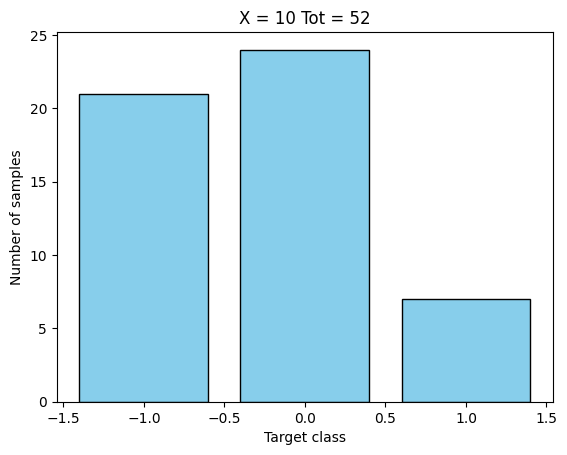

[21, 24, 7]


In [52]:
import matplotlib.pyplot as plt
target = [-1,0,1]

plt.bar( target ,[all_data_set[all_data_set["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = 10'+" Tot = " +str(all_data_set.shape[0]))

plt.show()
print([all_data_set[all_data_set["Target"] == t ].shape[0] for t in target])

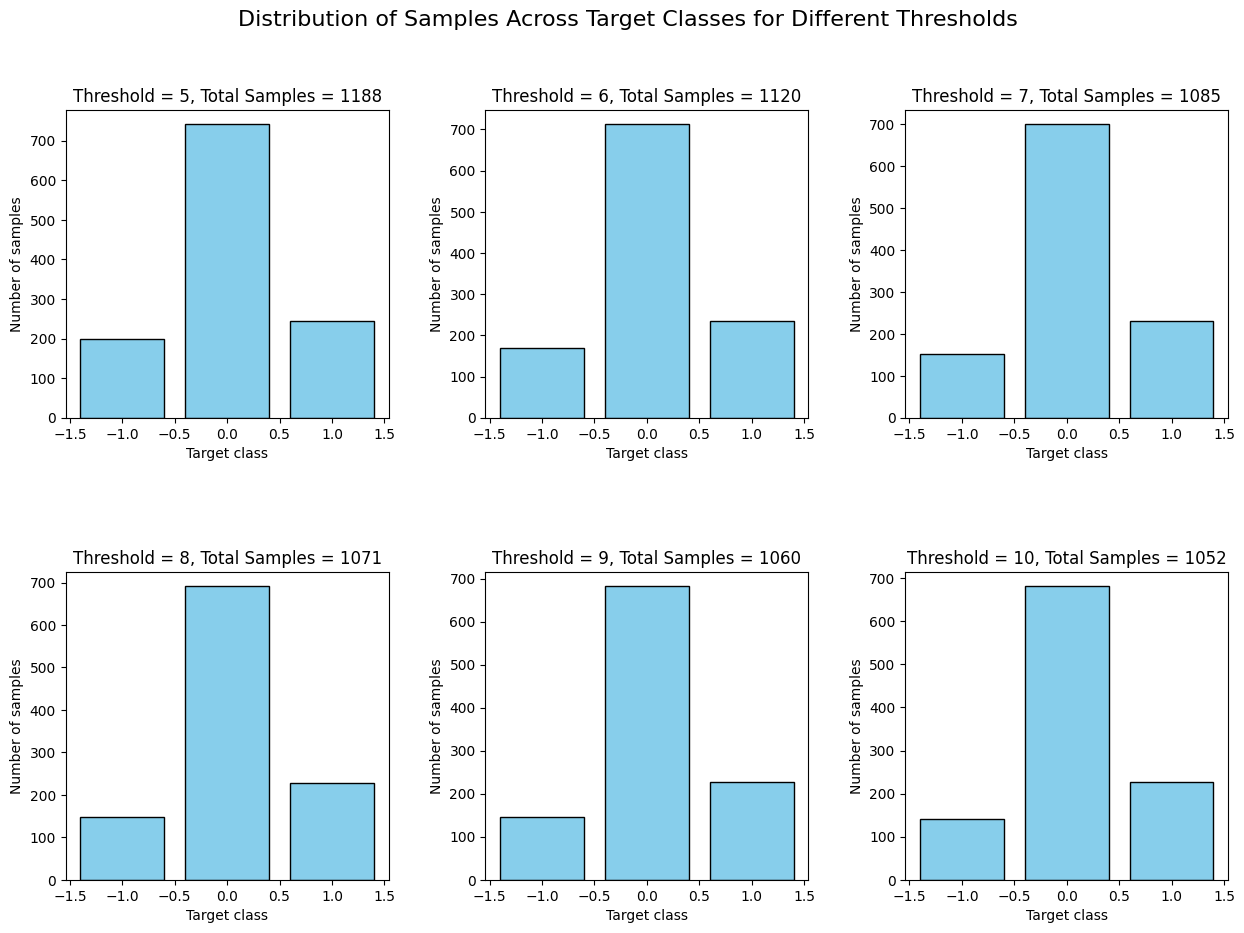

In [65]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = [5, 6, 7, 8, 9, 10]
file_list_1 = ["data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

for i, T in enumerate(threshold):
    row_index = i // 3
    col_index = i % 3

    all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold

    for file_name in file_list_2:
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            if len(articles_list) >= T:
                articles_list = articles_list[:T]
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()


In [66]:
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

all_data_set.head()

,Ticker,Article 1,Article 2,Article 3,Article 4,Article 5,Article 6,Article 7,Article 8,Article 9,Article 10,Target,Concatenated Titles
0,MMM,Here is What to Know Beyond Why 3M Company (MM...,What's Next For 3M Stock After A 15% Fall This...,MMM Stock Quote Price and Forecast - CNN,3M Announces Upcoming Investor Event - Yahoo F...,"Open Door: Claire Pentecost + Beth Jacobs, MMM...",Decoding 3M Co (MMM): A Strategic SWOT Insight...,3M (MMM) Rises But Trails Market: What Investo...,"Google Announces Meridian, A Marketing Mix Mod...",3M (NYSE:MMM) Will Pay A Larger Dividend Than ...,3M to unveil world's first self-charging prote...,0.0,Here is What to Know Beyond Why 3M Company (MM...
1,AOS,(AOS) Technical Data - Stock Traders Daily,GW hints at seven big Age of Sigmar 4th editio...,UCF Researcher Receives NIH Grant to Develop N...,GW Releases Free AoS &amp; Warcry Rules for th...,Age of Sigmar: Battlescroll Update Has A Big C...,"AOS 93, Coastal Rivers Conservation Trust Part...",The Compensation For A. O. Smith Corporation's...,Blount Boats delivers new CTV to American Offs...,Age of Sigmar: Saying Goodbye to Your Battleto...,Games Workshop culls 82 kits for Age of Sigmar...,0.0,(AOS) Technical Data - Stock Traders Daily GW ...
2,ABT,Explore the Seas in Style with the ABT Sportsl...,Abbott (ABT) Gains As Market Dips: What You Sh...,Abbott (ABT) Increases Yet Falls Behind Market...,"How I Got Hired: Talent Acquisition Partner, A...",The road-legal racing car - the ABT XGT - PR N...,"Abt XGT review: forget the Ferrari SF90 XX, yo...",Investors Heavily Search Abbott Laboratories (...,Abbott Laboratories (NYSE:ABT) Might Have The ...,ABT Stock Skids Within A Saucer Base Despite '...,Earnings Update: Abbott Laboratories (NYSE:ABT...,-1.0,Explore the Seas in Style with the ABT Sportsl...
3,ABBV,"AbbVie to Acquire Landos Biopharma, Further St...",AbbVie (NYSE:ABBV) Is Paying Out A Larger Divi...,AbbVie (ABBV) Announces Appointment of New CEO...,AbbVie (ABBV) Laps the Stock Market: Here's Wh...,"AbbVie (ABBV) Q3 Earnings Beat, Shares Down De...",AbbVie (ABBV) is a Top Dividend Stock Right No...,Will AbbVie (ABBV) Beat Estimates Again in Its...,AbbVie (ABBV) Beats on Q1 Earnings &amp; Sales...,AbbVie Inc (ABBV) Faces Headwinds Amid Declini...,AbbVie (ABBV) Beats Q1 Earnings and Revenue Es...,-1.0,"AbbVie to Acquire Landos Biopharma, Further St..."
4,ACN,What's in the Cards for Accenture (ACN) in Q1 ...,Accenture PLC (ACN) Reports Stable Revenues an...,Accenture (ACN) Up 4.2% Since Last Earnings Re...,How Is The Market Feeling About Accenture? - A...,Is Trending Stock Accenture PLC (ACN) a Buy No...,Is Accenture plc's (NYSE:ACN) Stock's Recent P...,Wall Street Analysts Think Accenture (ACN) Is ...,"At US$342, Is Accenture plc (NYSE:ACN) Worth L...",Accenture plc (ACN) Rose Strongly in Q4 - Yaho...,2024-05-06 | NYSE:ACN | Press Release | Accent...,0.0,What's in the Cards for Accenture (ACN) in Q1 ...


In [67]:
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = 10'+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])